In [1]:
import matplotlib.pyplot as plt

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = None, \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])



======================================================================================>      
   ✸       *           °                *      *                                            
        °   ✸           ▄███▄   ▄███▄  ▄████▄   ▄███▄ * ▄███▄    =>               ▄▄▄▄           
  ✸            °       ██*  ██ ██   ██ ██   ██ ██   ██ ██   ██   ====>         ▄█▀▀  ▀▀█▄        
   *   °    ✸          ██   ██ ██ ° ██ ██   ██ ██ * ██ ██   ██   ==>          █▀ ▄█▀▀█▄ ▀█       
✸    *             °   ██   ██ ██   ██ █████▀  ██▄▄▄██ ██   ██   =========>  █▀ █▀ ▄▄ ▀█ ▀█      
           ✸   °       ██ * ██ ██   ██ ██      ██▀▀▀██ ██   ██   ========>   █▄ █▄ ▀▀ ▄█ ▄█      
 *    ✸     °          ██   ██ ██   ██ ██  *   ██   ██ ██*  ██   =>           █▄ ▀█▄▄█▀ ▄█       
    °        *    ✸     ▀███▀   ▀███▀  ██    ° ██   ██  ▀███▀    ==>           ▀█▄▄  ▄▄█▀        
         ✸       *          *         *                                           ▀▀▀▀           
===========================

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

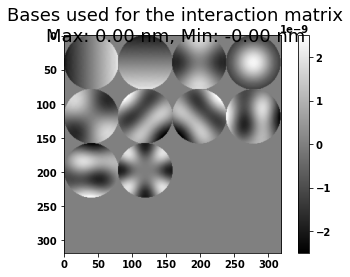

In [2]:
dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
plt.gray()
displayMap(tel.OPD)

Telescope and Atmosphere separated!
note, for this size basis, radial discretization on  40
points is finer than necessary - it should work, but you 
could take a smaller 'nr' without loss of accuracy


/mnt/home/usager/cars2019/anaconda3/envs/oopao_trwfs/lib/python3.10/site-packages/aotools/functions/karhunenLoeve.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  kernel[i, j, :] = tmp
/mnt/home/usager/cars2019/anaconda3/envs/oopao_trwfs/lib/python3.10/site-packages/aotools/functions/karhunenLoeve.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  kernel[j, i, :] = tmp
/mnt/home/usager/cars2019/anaconda3/envs/oopao_trwfs/lib/python3.10/site-packages/aotools/functions/karhunenLoeve.py:493: RuntimeWarning: divide by zero encountered in divide
  pincw = pincw * rebin(np.reshape(1.0 / np.sum(pincw, 0), (1, nr, npp)),


Text(0.5, 0, 'KL mode')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


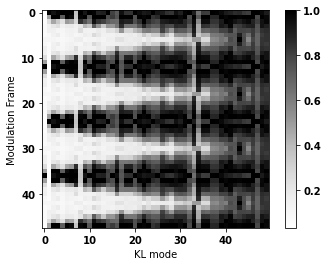

In [3]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = 50
stroke = 1*1e-9

i_cube = np.zeros((wfs.nTheta, 48**2, nModes))
# ngs.nPhoton = 10000000000

dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube.reshape(wfs.nTheta, 48**2)

bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)


for i in range(nModes):
    # atm.set_OPD(bases[i, :,:] * stroke)
    # tel+atm
    # tel*wfs

    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs


    push = wfs.cam.cube.reshape(wfs.nTheta, 48**2)

#push /= np.sum(push)

    # tel-atm
    # atm.set_OPD(bases[i, :,:] * -stroke)
    # tel+atm
    # tel*wfs
    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs

    pull = wfs.cam.cube.reshape(wfs.nTheta, 48**2)
    #pull /= np.sum(pull)

    i_cube[:,:,i] = (0.5 * (push - pull) / stroke)
    # imat_cube[:,:,i] = pull



plt.figure()

weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    weighting_cube[:,i] = weighting_cube[:,i] / np.max(weighting_cube[:,i])

im = plt.imshow(weighting_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 1.0, 'Weighted Interaction matrix')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


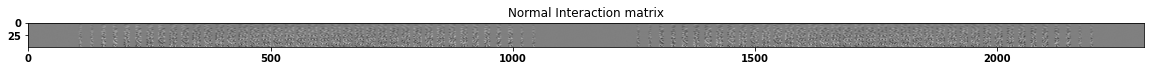

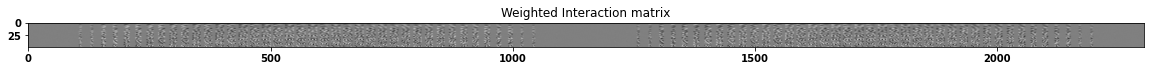

In [4]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = 50
stroke = 1*1e-9




# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)

def getInterationMatrix(weights, mod=5):
    imat = np.zeros((48**2, nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube.reshape(wfs.nTheta, 48**2)

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube.reshape(wfs.nTheta, 48**2)
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube.reshape(wfs.nTheta, 48**2)
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
    return imat


I_mat_normal = getInterationMatrix(np.ones((wfs.nTheta, nModes)))
I_mat_weighted = getInterationMatrix(weighting_cube)
# I_mat_weighted = getInterationMatrix(weighting_cube, mod=5)


I_mat_normal_inv = inv(I_mat_normal.T @ I_mat_normal) @ I_mat_normal.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T

plt.figure(figsize=(20,15))
plt.imshow(I_mat_normal.T)
plt.title(f"Normal Interaction matrix")
plt.figure(figsize=(20,15))
plt.imshow(I_mat_weighted.T)
plt.title(f"Weighted Interaction matrix")


Text(0.5, 1.0, 'Identity of TR reconstructor. RMS err = 6.574097671646676e-17')

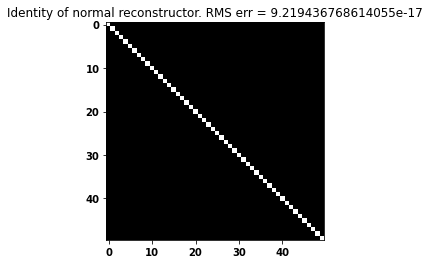

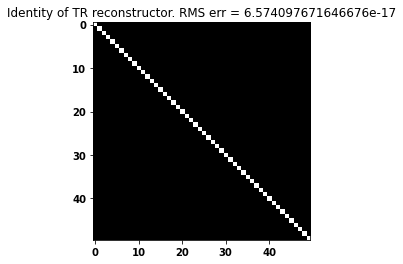

In [5]:
plt.figure()
plt.imshow(I_mat_normal_inv@I_mat_normal)
diag_normal_err_rms = np.sqrt(np.mean((I_mat_normal_inv@I_mat_normal - np.identity(nModes))**2))
plt.title(f"Identity of normal reconstructor. RMS err = {diag_normal_err_rms}")
plt.figure()
plt.imshow(I_mat_weighted_inv@I_mat_weighted)
diag_weighted_err_rms = np.sqrt(np.mean((I_mat_weighted_inv@I_mat_weighted - np.identity(nModes))**2))
plt.title(f"Identity of TR reconstructor. RMS err = {diag_weighted_err_rms}")




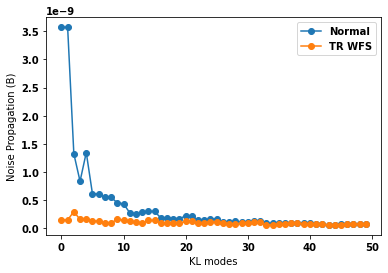

In [6]:
plt.figure()
plt.plot(np.diag(I_mat_normal_inv@I_mat_normal_inv.T), marker="o", label="Normal")
plt.plot(np.diag(I_mat_weighted_inv@I_mat_weighted_inv.T), marker="o", label="TR WFS")
plt.xlabel("KL modes")
plt.ylabel("Noise Propagation (B)")
plt.legend()

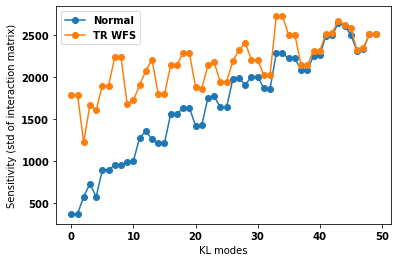

In [7]:
plt.figure()
plt.plot(np.std(I_mat_normal, axis=0), marker="o",label="Normal")
plt.plot(np.std(I_mat_weighted, axis=0), marker="o", label="TR WFS")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.legend()

Text(0.5, 1.0, 'Sensitivity with no noise for KL 2')

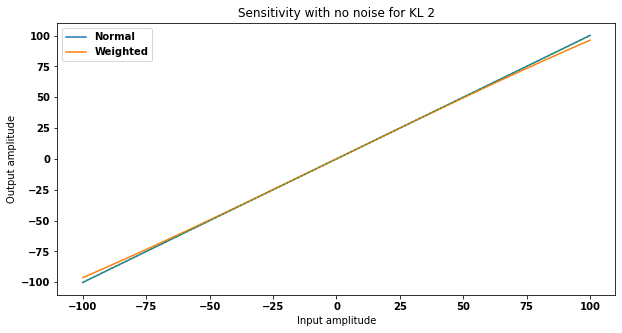

In [8]:
# Linearite des systemes
wfs.cam.photonNoise = False
amps = np.arange(-100, 101, 5)
normal_resp = np.zeros((len(amps)))
weighted_resp = np.zeros((len(amps)))
KL_mode_to_use = 2

for i in range(len(amps)):
    dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

    tel * dm * wfs

    signal = wfs.cam.cube.reshape(wfs.nTheta, 48**2)#[:, wfs.validSignal]

    normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                    np.sum(ref_cube, axis=0)/np.sum(ref_cube)
    weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                  np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])


    normal_resp[i] =  (I_mat_normal_inv@normal_signal)[KL_mode_to_use] / 1e-9
    weighted_resp[i] = (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9

plt.figure(figsize=(10,5))
plt.plot(amps, normal_resp, label="Normal")
plt.plot(amps, weighted_resp, label="Weighted")
plt.plot(amps, amps, ':')
plt.legend()
plt.xlabel("Input amplitude")
plt.ylabel("Output amplitude")
plt.title(f"Sensitivity with no noise for KL {KL_mode_to_use}")

Text(0.5, 1.0, 'Sensitivity with noise for KL 2')

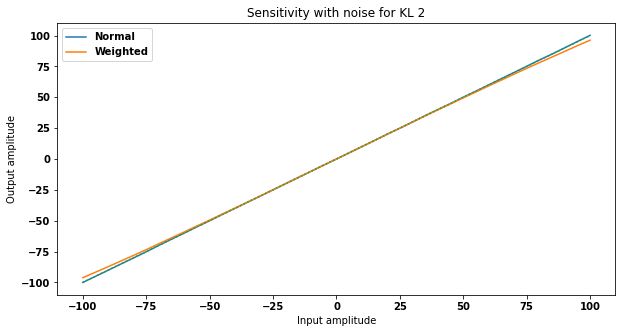

In [9]:
# Linearite des systemes
wfs.cam.photonNoise = True
amps = np.arange(-100, 101, 5)
normal_resp_noisy = np.zeros((len(amps)))
weighted_resp_noisy = np.zeros((len(amps)))
KL_mode_to_use = 2

for i in range(len(amps)):
    dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

    tel * dm * wfs

    signal = wfs.cam.cube.reshape(wfs.nTheta, 48**2)#[:, wfs.validSignal]

    normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                    np.sum(ref_cube, axis=0)/np.sum(ref_cube)
    weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                      np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])


    normal_resp_noisy[i] =  (I_mat_normal_inv@normal_signal)[KL_mode_to_use] / 1e-9
    weighted_resp_noisy[i] = (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9

plt.figure(figsize=(10,5))
plt.plot(amps, normal_resp_noisy, label="Normal")
plt.plot(amps, weighted_resp_noisy, label="Weighted")
plt.plot(amps, amps, ':')
plt.legend()
plt.xlabel("Input amplitude")
plt.ylabel("Output amplitude")
plt.title(f"Sensitivity with noise for KL {KL_mode_to_use}")

NGS flux updated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.79 	 [microns]
Optical Band 	I
Magnitude 	7.163789863713674
Flux 		10000000	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Text(0.5, 1.0, 'Error with noise for KL 2')

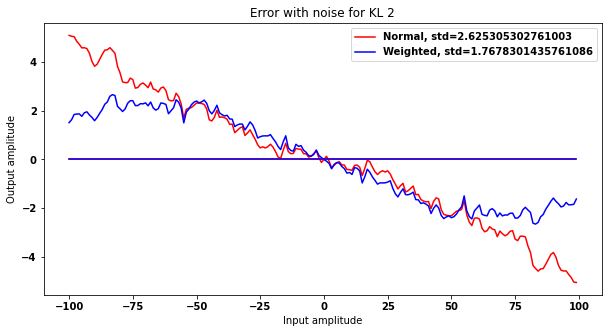

In [10]:
# Linearite des systemes
wfs.cam.photonNoise = False
amps = np.arange(-100, 100, 1)
iterations = 10
normal_err = np.zeros((len(amps), iterations))
weighted_err = np.zeros((len(amps), iterations))
KL_mode_to_use = 2

ngs.nPhoton = 10000000
ngs * tel

for i in range(len(amps)):
    dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

    tel * dm * wfs

    for j in range(iterations):

        signal_clean = wfs.cam.cube.reshape(wfs.nTheta, 48**2)#[:, wfs.validSignal]
        #signal = wfs.random_state_photon_noise.poisson(signal_clean)
        signal = np.int64(signal_clean)

        normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                        np.sum(ref_cube, axis=0)/np.sum(ref_cube)
        normal_signal = np.nan_to_num(normal_signal, nan=0)
        weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                          np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])
        weighted_signal = np.nan_to_num(weighted_signal, nan=0)


        normal_err[i, j] =  amps[i]  - (I_mat_normal_inv@normal_signal)[KL_mode_to_use] / 1e-9
        weighted_err[i, j] = amps[i]  - (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9

plt.figure(figsize=(10,5))
plt.plot(amps, np.mean(normal_err, axis=1), c='r',label=f"Normal, std={np.std(np.mean(normal_err, axis=1))}")
plt.plot(amps, np.mean(weighted_err, axis=1),c='b', label=f"Weighted, std={np.std(np.mean(weighted_err, axis=1))}")
plt.plot(amps, np.ones(len(amps))*np.mean(normal_err), c='r')
plt.plot(amps, np.ones(len(amps))*np.mean(weighted_err), c='b')
plt.legend()
plt.xlabel("Input amplitude")
plt.ylabel("Output amplitude")
plt.title(f"Error with noise for KL {KL_mode_to_use}")

NGS flux updated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.79 	 [microns]
Optical Band 	I
Magnitude 	17.916364852873627
Flux 		500	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Text(0.5, 1.0, 'Error with noise for KL 2')

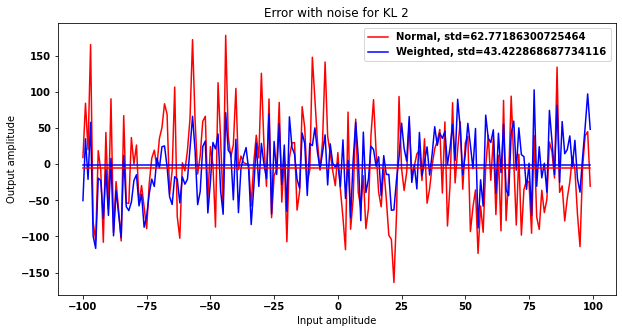

In [11]:
# Linearite des systemes
wfs.cam.photonNoise = False
amps = np.arange(-100, 100, 1)
iterations = 10
normal_err = np.zeros((len(amps), iterations))
weighted_err = np.zeros((len(amps), iterations))
KL_mode_to_use = 2

ngs.nPhoton = 500
ngs * tel

for i in range(len(amps)):
    a = np.zeros(M2C_KL.shape[1])

    a[:nModes] = generateA(nModes, 200*1e-9)
    a[KL_mode_to_use] = amps[i] * 1e-9
    dm.coefs = np.matmul(M2C_KL, a)

    tel * dm * wfs

    for j in range(iterations):

        signal_clean = wfs.cam.cube.reshape(wfs.nTheta, 48**2)#[:, wfs.validSignal]
        signal = wfs.random_state_photon_noise.poisson(signal_clean)

        normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                        np.sum(ref_cube, axis=0)/np.sum(ref_cube)
        weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                          np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])


        normal_err[i, j] =  amps[i]  - (I_mat_normal_inv@normal_signal)[KL_mode_to_use] / 1e-9
        weighted_err[i, j] = amps[i]  - (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9

plt.figure(figsize=(10,5))
plt.plot(amps, np.mean(normal_err, axis=1), c='r',label=f"Normal, std={np.std(np.mean(normal_err, axis=1))}")
plt.plot(amps, np.mean(weighted_err, axis=1),c='b', label=f"Weighted, std={np.std(np.mean(weighted_err, axis=1))}")
plt.plot(amps, np.ones(len(amps))*np.mean(normal_err), c='r')
plt.plot(amps, np.ones(len(amps))*np.mean(weighted_err), c='b')
plt.legend()
plt.xlabel("Input amplitude")
plt.ylabel("Output amplitude")
plt.title(f"Error with noise for KL {KL_mode_to_use}")

Text(0.5, 1.0, 'Error with noise for KL 40')

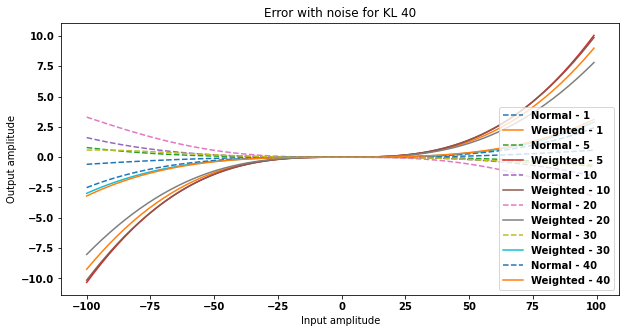

In [12]:
# Linearite des systemes
wfs.cam.photonNoise = False
amps = np.arange(-100, 100, 1)
normal_err_2 = np.zeros((len(amps)))
weighted_err_2 = np.zeros((len(amps)))
KL_mode_to_use = 40

plt.figure(figsize=(10,5))

for KL_mode_to_use in [1,5,10, 20, 30, 40]:
    for i in range(len(amps)):
        dm.coefs = M2C_KL[:,KL_mode_to_use] * amps[i] * 1e-9

        tel * dm * wfs

        signal = wfs.cam.cube.reshape(wfs.nTheta, 48**2)#[:, wfs.validSignal]

        normal_signal = np.sum(signal, axis=0)/np.sum(signal) - \
                        np.sum(ref_cube, axis=0)/np.sum(ref_cube)
        weighted_signal = np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(signal*weighting_cube[:, np.newaxis, KL_mode_to_use]) - \
                          np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, KL_mode_to_use])


        normal_err_2[i] =  amps[i]  - (I_mat_normal_inv@normal_signal)[KL_mode_to_use] / 1e-9
        weighted_err_2[i] = amps[i]  - (I_mat_weighted_inv@weighted_signal)[KL_mode_to_use] / 1e-9
    plt.plot(amps, normal_err_2,'--', label=f"Normal - {KL_mode_to_use}")
    plt.plot(amps, weighted_err_2, label=f"Weighted - {KL_mode_to_use}")


plt.legend()
plt.xlabel("Input amplitude")
plt.ylabel("Output amplitude")
plt.title(f"Error with noise for KL {KL_mode_to_use}")